In [2]:
!gdown --id 1RceyQijuEoLvbsRILQZEQ1X0Unsi45pN

Downloading...
From: https://drive.google.com/uc?id=1RceyQijuEoLvbsRILQZEQ1X0Unsi45pN
To: /content/ham10000_dataset.zip
711MB [00:05, 119MB/s] 


In [ ]:
#kaggle dataset will be directly downloaded to runtime disk of colab
! mkdir ~/.kaggle
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

 52% 2.72G/5.20G [00:41<01:04, 41.5MB/s]User cancelled operation


In [3]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/ham10000_dataset.zip' -d dataset/ | wc -l
!unzip *.zip
!rm -r '/content/ds/train/.ipynb_checkpoints/'

Streaming output truncated to the last 5000 lines.
  inflating: ds/train/nv/ISIC_0033148.jpg.jpg  
  inflating: ds/train/nv/ISIC_0032434.jpg.jpg  
  inflating: ds/train/nv/ISIC_0029628.jpg.jpg  
  inflating: ds/train/nv/ISIC_0026359.jpg.jpg  
  inflating: ds/train/nv/ISIC_0033188.jpg.jpg  
  inflating: ds/train/nv/ISIC_0032354.jpg.jpg  
  inflating: ds/train/nv/ISIC_0028292.jpg.jpg  
  inflating: ds/train/nv/ISIC_0026752.jpg.jpg  
  inflating: ds/train/nv/ISIC_0027520.jpg.jpg  
  inflating: ds/train/nv/ISIC_0032332.jpg.jpg  
  inflating: ds/train/nv/ISIC_0028668.jpg.jpg  
  inflating: ds/train/nv/ISIC_0029888.jpg.jpg  
  inflating: ds/train/nv/ISIC_0032729.jpg.jpg  
  inflating: ds/train/nv/ISIC_0028157.jpg.jpg  
  inflating: ds/train/nv/ISIC_0024327.jpg.jpg  
  inflating: ds/train/nv/ISIC_0028599.jpg.jpg  
  inflating: ds/train/nv/ISIC_0030900.jpg.jpg  
  inflating: ds/train/nv/ISIC_0030355.jpg.jpg  
  inflating: ds/train/nv/ISIC_0027944.jpg.jpg  
  inflating: ds/train/nv/ISIC_0024721

In [ ]:
! ls /content/dataset/ham10000_images_part_1

In [10]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from tensorflow import keras
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.applications import VGG19, ResNet50
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import CategoricalCrossentropy
import pandas as pd
import shutil
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K

In [ ]:
# # DataFrame for labelling

# df = pd.read_csv('/content/dataset/HAM10000_metadata.csv')
# df.index = df['image_id']
# df = df['dx']
# df.to_csv('/content/dataset/image_labelling.csv')

In [ ]:
# for i in tqdm(os.listdir('/content/dataset/HAM10000_images_part_2')):
#     path = '/content/ds/train/'+df[i.split('.')[0]]+'/'+i+'.jpg'
#     img = cv2.imread("/content/dataset/HAM10000_images_part_2/"+i)
#     cv2.imwrite(path,img)
#     #!cp "/content/dataset/HAM10000_images_part_1/$i" path

100%|██████████| 5015/5015 [01:04<00:00, 77.27it/s]


In [ ]:
# ! ls /content/ds/train/vasc | wc -l

142


In [ ]:
# for i in df.unique():
#     !mkdir "ds/train/$i"

In [ ]:
! zip ham10000_dataset.zip -r ds | wc -l

10027


In [5]:
df = pd.read_csv('/content/ds/image_labelling.csv')
_,class_weights = np.unique(df['dx'],return_counts=True)
class_weights = 1/class_weights
class_weights = class_weights/np.sum(class_weights)
class_weights

array([0.13472377, 0.08570948, 0.04008614, 0.3830841 , 0.03958192,
       0.00657042, 0.31024417])

In [ ]:
# for i,j in tqdm(zip(os.listdir('/content/dataset/HAM10000_images_part_2'), os.listdir('/content/dataset/ham10000_images_part_2'))):
#     im1 = cv2.imread('/content/dataset/HAM10000_images_part_2/'+i)
#     im2 = cv2.imread('/content/dataset/ham10000_images_part_2/'+j)
#     if(np.sum(im1-im2) != 0):
#       print('oh')
#       break
# print('done')

5015it [01:32, 54.24it/s]

done


In [ ]:
# for i,j in tqdm(zip(os.listdir('/content/dataset/HAM10000_images_part_1'), os.listdir('/content/dataset/HAM10000_images_part_2')[:5000])):
#     s.add(cv2.imread('/content/dataset/HAM10000_images_part_1/'+i).shape)
#     s.add(cv2.imread('/content/dataset/HAM10000_images_part_2/'+j).shape)
# print('done')

5000it [01:30, 55.15it/s]

done


In [185]:
goodshape = (256,256,3)

In [103]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [192]:
def process_images(img):
    #cv2_imshow(img)
    #print(img.shape)
    #gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
  
    # clahe = cv.createCLAHE()
    # final_img = clahe.apply(gray)

    final_img = cv.equalizeHist(gray)
      
    img3 = cv.cvtColor(final_img,cv.COLOR_GRAY2RGB)
    # print(img.shape)
    # gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # print(gray.shape)
    # clahe = cv2.createCLAHE(clipLimit = 5)
    # final_img = clahe.apply(gray)
    # print(final_img.shape)
    # img3 = cv.cvtColor(final_img,cv.COLOR_GRAY2RGB)
    return preprocess_input(img3)

In [198]:
train_generator = ImageDataGenerator(
    validation_split=0.15,
    preprocessing_function=preprocess_input,
    )

# valid_generator = ImageDataGenerator(
#     rescale=1/255.0,
#     horizontal_flip= True)

In [199]:
train_gen = train_generator.flow_from_directory(
    '/content/ds/train',
    target_size = goodshape[:2],
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=True,
    seed=2211,
    interpolation='lanczos',
    subset='training',
)

valid_gen = train_generator.flow_from_directory(
    '/content/ds/train',
    target_size = goodshape[:2],
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=False,
    interpolation='lanczos',
    subset='validation'
)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.


In [200]:
loss_fun = weighted_categorical_crossentropy(class_weights)

In [201]:
pretrained = VGG19(include_top=False, weights='imagenet', input_shape=goodshape)

# Flatten or GlobalMaxPooling
for i in pretrained.layers:
    i.trainable = False

ip = pretrained.input

op = pretrained.output

flatten = Flatten()(op)

dense1 = Dense(256, activation='relu')(flatten)

do1 = Dropout(0.2)(dense1)

dense2 = Dense(64,activation='relu')(do1)

do2 = Dropout(0.2)(dense2)

opMain = Dense(train_gen.num_classes,activation='softmax')(do2)

model = Model(inputs=ip, outputs=opMain)

In [202]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0  

In [161]:
class_weights

array([0.13472377, 0.08570948, 0.04008614, 0.3830841 , 0.03958192,
       0.00657042, 0.31024417])

In [203]:
model.compile(optimizer = Adam(learning_rate=0.0001), metrics=['accuracy'], loss=loss_fun)

In [207]:
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=np.ceil(train_gen.n/train_gen.batch_size), validation_steps=np.ceil(valid_gen.n/valid_gen.batch_size), epochs=5)

Epoch 1/5
267/267 [==============================] - 121s 451ms/step - loss: 0.0225 - accuracy: 0.6801 - val_loss: 0.0362 - val_accuracy: 0.7165
Epoch 2/5
267/267 [==============================] - 121s 452ms/step - loss: 0.0200 - accuracy: 0.7030 - val_loss: 0.0390 - val_accuracy: 0.6451
Epoch 3/5
267/267 [==============================] - 121s 453ms/step - loss: 0.0157 - accuracy: 0.7452 - val_loss: 0.0410 - val_accuracy: 0.7418
Epoch 4/5
267/267 [==============================] - 121s 453ms/step - loss: 0.0160 - accuracy: 0.7506 - val_loss: 0.0421 - val_accuracy: 0.7151
Epoch 5/5
267/267 [==============================] - 121s 453ms/step - loss: 0.0143 - accuracy: 0.7777 - val_loss: 0.0376 - val_accuracy: 0.7445


In [211]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [208]:
valid_gen.reset()
Y_pred = model.predict(valid_gen, steps=np.ceil(valid_gen.n/valid_gen.batch_size), verbose=1)

47/47 [==============================] - 18s 392ms/step


In [209]:
print(classification_report(valid_gen.classes, Y_pred.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.41      0.55      0.47        49
           1       0.58      0.65      0.61        77
           2       0.53      0.60      0.56       164
           3       0.40      0.59      0.48        17
           4       0.39      0.51      0.44       166
           5       0.93      0.83      0.88      1005
           6       0.64      0.67      0.65        21

    accuracy                           0.74      1499
   macro avg       0.55      0.63      0.58      1499
weighted avg       0.78      0.74      0.76      1499



In [23]:
print(classification_report(valid_gen.classes, Y_pred.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.13      0.59      0.21        49
           1       0.30      0.71      0.42        77
           2       0.24      0.13      0.17       164
           3       0.04      0.65      0.08        17
           4       0.33      0.49      0.40       166
           5       0.98      0.42      0.59      1005
           6       0.20      0.62      0.30        21

    accuracy                           0.43      1499
   macro avg       0.32      0.52      0.31      1499
weighted avg       0.74      0.43      0.49      1499



In [172]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
img = cv.imread('/content/ds/train/akiec/ISIC_0024329.jpg.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  
# The declaration of CLAHE 
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=4)
final_img = clahe.apply(gray)
  
# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
#img2 = cv.equalizeHist(gray)
img3 = cv.cvtColor(final_img,cv.COLOR_GRAY2RGB)

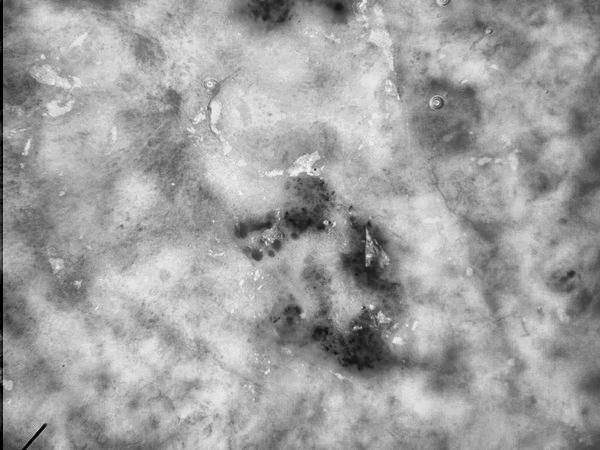

In [173]:
cv2_imshow(preprocess_input(final_img))

In [46]:
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [47]:
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [48]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [210]:
model.save('model_main',save_format='h5')